In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab import drive

drive.mount("/content/drive")
cuda = torch.cuda.is_available()
device = "cuda:0" if cuda else "cpu"
print("cuda: ", cuda)

In [ ]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = torch.nn.Linear(16 * 4 * 4, 120)
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)

    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.max_pool2d(x, 2)
        x = torch.nn.functional.relu(self.conv2(x))
        x = torch.nn.functional.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x


cnn = CNN()

if cuda:
    cnn.to(device)

In [ ]:
def train(num_epochs, cnn, loaders):
    cnn.train()

    total_step = len(loaders["train"])
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=0.007)

    train_loss_history = []
    val_loss_history = []
    train_accuracy_history = []
    val_accuracy_history = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, (images, labels) in enumerate(loaders["train"]):
            if cuda:
                images = images.to(device)
                labels = labels.to(device)

            b_x = torch.autograd.Variable(images)
            b_y = torch.autograd.Variable(labels)

            output = cnn(b_x)
            loss = loss_function(output, b_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            _, predicted_train = torch.max(output.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

            if (i + 1) % 100 == 0:
                print(
                    "Epoch [{}/{}] | Step [{}/{}] | Loss: {:.3f}".format(
                        epoch + 1, num_epochs, i + 1, total_step, loss.item()
                    )
                )

        train_loss_history.append(epoch_loss / total_step)
        train_accuracy_history.append(100 * correct_train / total_train)

        cnn.eval()

        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in loaders["val"]:
                if cuda:
                    images = images.to(device)
                    labels = labels.to(device)

                outputs = cnn(images)
                loss = loss_function(outputs, labels)
                val_loss += loss.item()

                _, predicted_val = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()

            print("Validation accuracy: {} %".format(100 * correct_val / total_val))

        val_loss_history.append(val_loss / len(loaders["val"]))
        val_accuracy_history.append(100 * correct_val / total_val)

        cnn.train()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, "-", label="Train Loss")
    plt.plot(val_loss_history, "-", label="Validation Loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_history, "-", label="Train Accuracy")
    plt.plot(val_accuracy_history, "-", label="Validation Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

In [ ]:
batch_size = 100

data = {
    "train": torchvision.datasets.MNIST(
        root="data",
        train=True,
        transform=torchvision.transforms.ToTensor(),
        download=True,
    ),
    "test": torchvision.datasets.MNIST(
        root="data", train=False, transform=torchvision.transforms.ToTensor()
    ),
}

train_data, val_data = train_test_split(
    data["train"], train_size=50000, test_size=10000, random_state=27
)

loader = {
    "train": torch.utils.data.DataLoader(
        train_data, batch_size, shuffle=False, num_workers=1
    ),
    "val": torch.utils.data.DataLoader(
        val_data, batch_size, shuffle=False, num_workers=1
    ),
}

Epoch [1/13] | Step [100/500] | Loss: 0.083
Epoch [1/13] | Step [200/500] | Loss: 0.145
Epoch [1/13] | Step [300/500] | Loss: 0.140
Epoch [1/13] | Step [400/500] | Loss: 0.062
Epoch [1/13] | Step [500/500] | Loss: 0.054
Validation accuracy: 97.17 %
Epoch [2/13] | Step [100/500] | Loss: 0.013
Epoch [2/13] | Step [200/500] | Loss: 0.039
Epoch [2/13] | Step [300/500] | Loss: 0.076
Epoch [2/13] | Step [400/500] | Loss: 0.074
Epoch [2/13] | Step [500/500] | Loss: 0.068
Validation accuracy: 97.68 %
Epoch [3/13] | Step [100/500] | Loss: 0.011
Epoch [3/13] | Step [200/500] | Loss: 0.028
Epoch [3/13] | Step [300/500] | Loss: 0.062
Epoch [3/13] | Step [400/500] | Loss: 0.053
Epoch [3/13] | Step [500/500] | Loss: 0.054
Validation accuracy: 97.65 %
Epoch [4/13] | Step [100/500] | Loss: 0.033
Epoch [4/13] | Step [200/500] | Loss: 0.080
Epoch [4/13] | Step [300/500] | Loss: 0.072
Epoch [4/13] | Step [400/500] | Loss: 0.033
Epoch [4/13] | Step [500/500] | Loss: 0.011
Validation accuracy: 98.48 %
Epoc

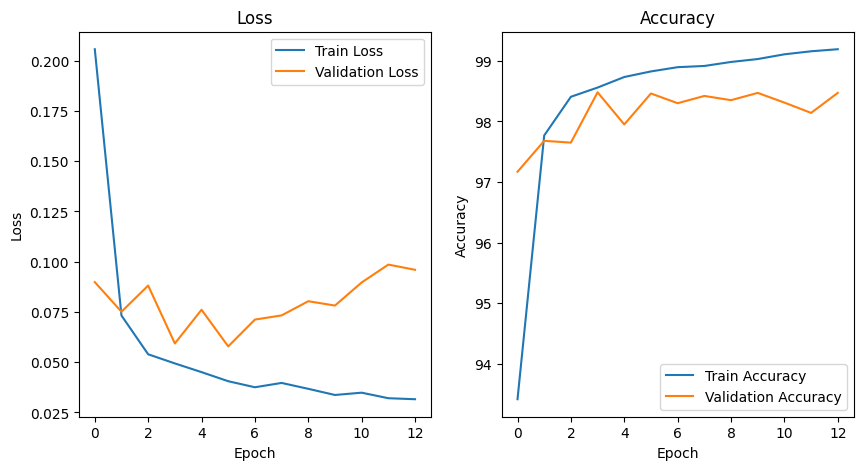

In [ ]:
train(13, cnn, loader)
torch.save(cnn.state_dict(), "/content/drive/MyDrive/CNNs/Torch/cnn.pth")